source: https://towardsdatascience.com/mnist-cnn-python-c61a5bce7a19

# Title

In [1]:
# Import modules
import numpy as np
import pandas as pd
import struct
import gzip
import tensorflow as tf
from matplotlib import pyplot as plt

# Split into 3 local section

Tasked to split the data set into 3 local section. Train a model for each section, then combine them to a global model. Therefore we must split the data into three section:

- One for digits 0-2
- One for digits 3-5
- One for digits 6-9

In [6]:
def split_into_section(features, labels, lower_boud, upper_boud):
  new_features = []
  new_labels = []
  
  for i in range(len(features)):
    if lower_boud <= labels[i] <= upper_boud:
      new_features.append(features[i])
      new_labels.append(labels[i])

  return new_features, new_labels

In [7]:
train_X_group_one, train_y_group_one = split_into_section(train_X, train_y, 0, 2)
train_X_group_two, train_y_group_two = split_into_section(train_X, train_y, 3, 5)
train_X_group_three, train_y_group_three = split_into_section(train_X, train_y, 6, 9)

test_X_group_one, test_y_group_one = split_into_section(test_X, test_y, 0, 2)
test_X_group_two, test_y_group_two = split_into_section(test_X, test_y, 3, 5)
test_X_group_three, test_y_group_three = split_into_section(test_X, test_y, 6, 9)

Next I want to verify that I split the section correct, so I print out the first 9 images of each section:

Group 1 (0-2)


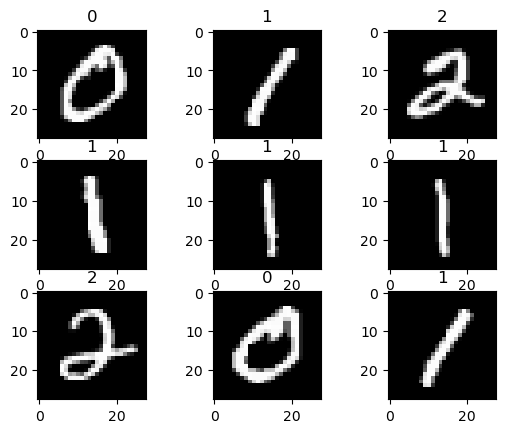

Group 2 (3-5)


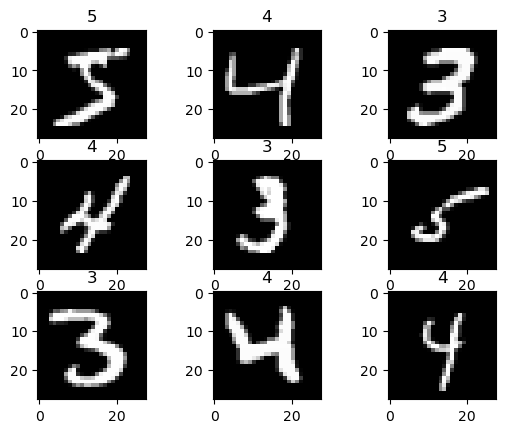

Group 3 (6-9)


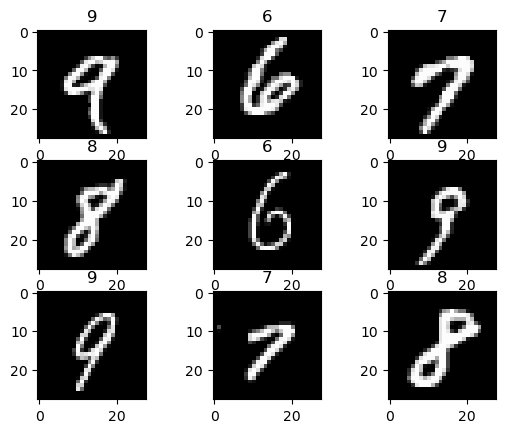

In [8]:
print("Group 1 (0-2)")
for i in range(9):
  subplot = plt.subplot(330 + 1 + i)
  subplot.set_title(train_y_group_one[i])
  plt.imshow(train_X_group_one[i], cmap='gray')
plt.show()

print("Group 2 (3-5)")
for i in range(9):
  subplot = plt.subplot(330 + 1 + i)
  subplot.set_title(train_y_group_two[i])
  plt.imshow(train_X_group_two[i], cmap='gray')
plt.show()

print("Group 3 (6-9)")
for i in range(9):
  subplot = plt.subplot(330 + 1 + i)
  subplot.set_title(train_y_group_three[i])
  plt.imshow(train_X_group_three[i], cmap='gray')
plt.show()

## Load the dataset

First we need to load the data so we have something to work with. Im using keras dataset and storeing the data in the minst variable

In [139]:
mnist = tf.keras.datasets.mnist

Next lets split the data into train and test set, where `train_X` and `train_y` are the features and labels for the train set. The same applies for the test set, `test_X` and `text_y` are the features and labels for this test set.

In [156]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

## Visualize the data

Now that we have the data, let's visualize it to make a better understanding of what we are working with.

First I want to print out the shape of each "sub data set"

In [142]:
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test: ' + str(test_X.shape))
print('Y_test: ' + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test: (10000, 28, 28)
Y_test: (10000,)


From the output above we can see that the train set contains of 60000 rows with 28 * 28 features. That is 28 * 28 pixels representing a handwritten number. Each pixels is then a number between 0-255 to represent the grey-scale of that particular pixel. There are also 600000 labels, with a number between 0-9 that tells which number is drawn in each picture.

The test set is 1/6 the size of the train set with 10000 rows, each row has 28 * 28 features (again 28 * 28 pixels) and one label with a number between 0-9.

Next let's plot the first 9 digits of the train set

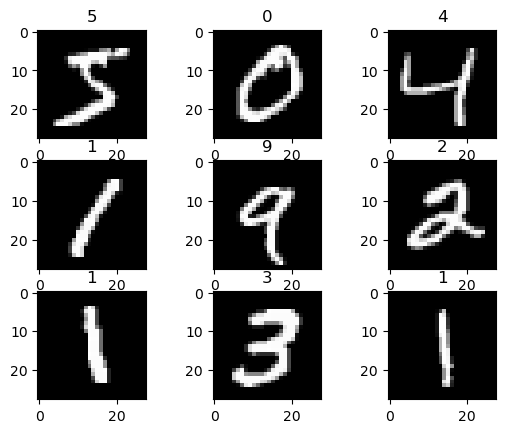

In [126]:
for i in range(9):
  subplot = plt.subplot(330 + 1 + i)
  subplot.set_title(train_y[i])
  plt.imshow(train_X[i], cmap='gray')
plt.show()

# Reshape the data

Before we can create a model and train it, we have to do some preprocessing of the data. I will create a function that takes in the train features and labels as well as the test features and labels. The function will then process the data and return the finished processed data. I will then call this function after I have split the data into 3 groups

In [151]:
def preprocess_data(train_X, train_y, test_X, test_y):
  # Convert to numpy array
  train_X = np.array(train_X)
  train_y = np.array(train_y)
  test_X = np.array(test_X)
  test_y = np.array(test_y)

  # Reshape the data
  train_X = train_X.reshape(train_X.shape[0], 28, 28, 1)
  test_X = test_X.reshape(test_X.shape[0], 28, 28, 1)

  # Normalize the data
  train_X = train_X / 255.0
  test_X = test_X / 255.0

  # One-hot encode the labels
  train_y = tf.keras.utils.to_categorical(train_y)
  test_y = tf.keras.utils.to_categorical(test_y)

  return train_X, train_y, test_X, test_y

  - Firstly I convert the current sets into np.arrays as these are easier to work with.
  - Next I convert the numbers into floating decimals
  - Now I want to normalize the data and since each pixel is represented by a value between 0 and 255, I can divid each pixel by 255 to get a number between 0 and 1
  - Lastly I want to convert the labels into one hot encoding. They are currently represented by a digit between 0 and 9. For this set that mean creating an array for each label with 9 items. Each item is initialy set to 0 and one of the digit will have to be 1 depending on which number is should represent. 
    - For example if the item at index 0 is set to 1 and the rest are 0, that means that the array represents the number 0. If the item at index 5 is set to 1 and the rest are 0, that means that the array represents the number 6.

## Splitting the data

In [158]:
train_X_group_one = []
train_y_group_one = []

for i in range(len(train_X)):
  if train_y[i] <= 2:
    train_X_group_one.append(train_X[i])
    train_y_group_one.append(train_y[i])

train_X_group_two = []
train_y_group_two = []

for i in range(len(train_X)):
  if 3 <= train_y[i] <= 5:
    train_X_group_two.append(train_X[i])
    train_y_group_two.append(train_y[i])

train_X_group_three = []
train_y_group_three = []

for i in range(len(train_X)):
  if 6 <= train_y[i] <= 9:
    train_X_group_three.append(train_X[i])
    train_y_group_three.append(train_y[i])

train_X_group_one, train_y_group_one, test_X_group_one, test_y_group_one = preprocess_data(train_X_group_one, train_y_group_one, test_X_group_one, test_y_group_one)
train_X_group_two, train_y_group_two, test_X_group_two, test_y_group_two = preprocess_data(train_X_group_two, train_y_group_two, test_X_group_two, test_y_group_two)
train_X_group_three, train_y_group_three, test_X_group_three, test_y_group_three = preprocess_data(train_X_group_three, train_y_group_three, test_X_group_three, test_y_group_three)

TypeError: int() argument must be a string, a bytes-like object or a number, not 'NoneType'

## Create the model

Now that we are done with processing the data, we can finally start creating the model.

In [90]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
# Create the first model
model_one = tf.keras.models.Sequential()
# Add the first convolutional layer
model_one.add(tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)))
# Add a pooling layer
model_one.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Add another convolutional layer
model_one.add(tf.keras.layers.Conv2D(32, (5,5), activation='relu'))
# Add another pooling layer
model_one.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Flatten the results to feed into a DNN
model_one.add(tf.keras.layers.Flatten())
# 512 neuron hidden layer
model_one.add(tf.keras.layers.Dense(512, activation='relu'))
# Only 10 outputs, one for each digit
# Softmax for probability distribution
model_one.add(tf.keras.layers.Dense(3, activation='softmax'))

# Compile the model
model_one.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model_one.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_30 (Dense)             (None, 3)               

In [88]:
# Create the second model
model_two = tf.keras.models.Sequential()
# Add the first convolutional layer
model_two.add(tf.keras.layers.Conv2D(32, (5,5), activation='relu', input_shape=(28,28,1)))
# Add a pooling layer
model_two.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Add another convolutional layer
model_two.add(tf.keras.layers.Conv2D(32, (5,5), activation='relu'))
# Add another pooling layer
model_two.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Flatten the results to feed into a DNN
model_two.add(tf.keras.layers.Flatten())
# 512 neuron hidden layer
model_two.add(tf.keras.layers.Dense(512, activation='relu'))
# Only 10 outputs, one for each digit
# Softmax for probability distribution
model_two.add(tf.keras.layers.Dense(3, activation='softmax'))

# Compile the model
model_two.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model_two.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_32 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 8, 8, 32)          25632     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_33 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_34 (Dense)             (None, 3)               

## Train the model

The second to last step is to use our data to train the model. Here I used a batch size of 256 meaning that for each epoch only 256 samples from the dataset will be evaluated. The epochs are set to 10. This infers that the model will use 10 iteration when training. Lastly the validation split is set to 0.2. This means that 20% of the data will be used as validation under training to make sure the model is not overfitting.

In [79]:
history_group_one = model_one.fit(train_X_group_one, train_y_group_one, batch_size=256, epochs=10, validation_split=0.2)

Train on 14898 samples, validate on 3725 samples
Epoch 1/10
14898/14898 [==============================] - 7s 492us/sample - loss: 0.8538 - accuracy: 0.6283 - val_loss: 0.2968 - val_accuracy: 0.9071
Epoch 2/10
14898/14898 [==============================] - 6s 396us/sample - loss: 0.1669 - accuracy: 0.9456 - val_loss: 0.1059 - val_accuracy: 0.9672
Epoch 3/10
14898/14898 [==============================] - 6s 397us/sample - loss: 0.0865 - accuracy: 0.9721 - val_loss: 0.0828 - val_accuracy: 0.9713
Epoch 4/10
14898/14898 [==============================] - 6s 425us/sample - loss: 0.0687 - accuracy: 0.9770 - val_loss: 0.0599 - val_accuracy: 0.9807
Epoch 5/10
14898/14898 [==============================] - 7s 451us/sample - loss: 0.0561 - accuracy: 0.9827 - val_loss: 0.0686 - val_accuracy: 0.9791
Epoch 6/10
14898/14898 [==============================] - 7s 450us/sample - loss: 0.0510 - accuracy: 0.9832 - val_loss: 0.0463 - val_accuracy: 0.9834
Epoch 7/10
14898/14898 [===========================

In [91]:
history = model.fit(train_X_group_three, train_y_group_three, batch_size=256, epochs=10, validation_split=0.2)

Train on 19186 samples, validate on 4797 samples
Epoch 1/10
19186/19186 [==============================] - 10s 501us/sample - loss: 1.5364 - accuracy: 0.2451 - val_loss: 1.3863 - val_accuracy: 0.2431
Epoch 2/10
19186/19186 [==============================] - 8s 421us/sample - loss: 1.3839 - accuracy: 0.2808 - val_loss: 1.3770 - val_accuracy: 0.2387
Epoch 3/10
19186/19186 [==============================] - 8s 409us/sample - loss: 1.3356 - accuracy: 0.3931 - val_loss: 1.2182 - val_accuracy: 0.7175
Epoch 4/10
19186/19186 [==============================] - 8s 395us/sample - loss: 0.8398 - accuracy: 0.7879 - val_loss: 0.4203 - val_accuracy: 0.8910
Epoch 5/10
19186/19186 [==============================] - 9s 460us/sample - loss: 0.3340 - accuracy: 0.8950 - val_loss: 0.2477 - val_accuracy: 0.9243
Epoch 6/10
19186/19186 [==============================] - 9s 469us/sample - loss: 0.2436 - accuracy: 0.9181 - val_loss: 0.1996 - val_accuracy: 0.9358
Epoch 7/10
19186/19186 [==========================

In [82]:
print(train_y_group_two[0])
print(train_y_group_three[0])

[0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


After training the model we can plot the loss curve together with the validation curve. This tells us the the accuracy started very low, but got better fast in the beginning and started to slow down as we aproached the last iterations.

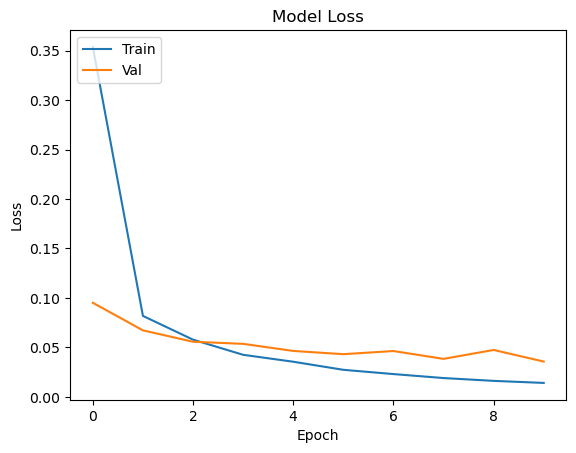

In [59]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

## Validation

Finally we have to validate our model. This is very we will use our test data set. It's important that the model has never seen this data before (e.g. not been used under training) so we don't get a false result.

In [60]:
test_loss, test_acc = model.evaluate(test_X, test_y_one_hot)
print('Test accuracy:', test_acc)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================